# Time series classification for fault detection in thermoforming machines

<font color=red>This project was part of a university seminar in cooperation with an industry partner. The data is confidential and I am not allowed to share it. I left sample data for every group, so you are able to follow the code.</font>

***

## Thermoforming example
![Thermoforming](https://pri-plastics.com/wp-content/uploads/2020/06/Thermoforming-Process.jpg)

## Task description
The aim of this project is "inline" detection of incomplete molded products (e. g. of yoghurt cups) based on the pressure curve. The aim is not *early time series classification*, because the molding a product only take a short amount of time and cannot be interrupted.

The data gathered during an experiment and contains measurements from different sensors. Only the pressure sensor data should be used.The sensor has a sampling rate of 1ms. 

Four different classes of outcomes were present:
1. Group A - not formed *(Ger.: Gruppe A - nicht ausgeformt)*
2. Group B - without bottom *(Ger.: Gruppe B - ohne Boden)*
3. Group B - incomplete bottom *(Ger.: Gruppe B - Boden berührt)*
4. Group A - formed *(Ger.: Gruppe A - ausgeformt)*

The class **not formed** means that the foil was not heated and therefore not formed. 

The class **formed** means that there is a complete mapping of the outer shape contour of the molded part.

The class **without bottom** denotes molded parts which have been formed but have not reached the bottom of the mold. Therefore they are  incompletely formed.

The class **incomplete bottom** also designates incompletely formed molded parts, but the bottom of the molded part has been reached. However, the molding does not extend completely into the mold.

So the only desirable outcome is correctly **formed** product. The other three classes represent faults of different severity. In the above the classes are sorted by severity.

## Setup

### virtual enviroment and packages
Use OS level shell to setup the enviroment. Setup in the correct folder!
Please use python 3.10. Package sktime does not work with 3.11 at the moment.

In [2]:
# Guide: How to use virtual env with jupyter: https://codemuch.net/posts/vscode_jupyter_notebook/
# pip install virtualenv
# python -m virtualenv rocket
# rocket\Scripts\activate
# pip install ipykernel 
# python -m ipykernel install --user --name=rocket

In [3]:
#pip install pandas numpy matplotlib tensorflow sktime[all_extras] keras attrs

### install packages
importing Rocket may take some time during the first import

In [28]:
import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,plot_confusion_matrix
from sklearn.dummy import DummyClassifier

from sktime.transformations.panel.rocket import Rocket
from sktime.transformations.panel.rocket import MiniRocket
from sktime.datatypes._panel._convert import (from_3d_numpy_to_nested)

#import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [3]:
# Set random seed
seed = 9999
np.random.seed(seed)

# Suppress scientific notation
np.set_printoptions(suppress = True)


## Pre-Processing

### Read files from different directories

In [4]:
li = []

# Gruppe A - Zustand ausgeformt
path = "./data/Gruppe A/Zustand ausgeformt" 
all_files = glob.glob(path + "/*.csv")

for filename in all_files:
    df = pd.read_csv(filename, encoding="latin-1", sep=";", header=0, usecols=[0,5], index_col=None)
    df["Group"] = "A - ausgeformt"
    df["ID"] = os.path.basename(filename) 
    li.append(df)
   
# Gruppe A - Zustand nicht ausgeformt
path = "./data/Gruppe A/Zustand nicht ausgeformt" 
all_files = glob.glob(path + "/*.csv")

for filename in all_files:
    df = pd.read_csv(filename, encoding="latin-1", sep=";", header=0, usecols=[0,5], index_col=None)
    df["Group"] = "A - nicht ausgeformt"
    df["ID"] = os.path.basename(filename)
    li.append(df)

# Gruppe B - ohne Boden 
path = "./data/Gruppe B/nicht vollst ausgeformt - ohne Boden" 
all_files = glob.glob(path + "/*.csv")

for filename in all_files:
    df = pd.read_csv(filename, encoding="latin-1", sep=";", header=0, usecols=[0,5], index_col=None)
    df["Group"] = "B - ohne Boden"
    df["ID"] = os.path.basename(filename)
    li.append(df)

# Gruppe B - Boden berührt 
path = "./data/Gruppe B/nicht vollst ausgeformt - Boden berührt" 
all_files = glob.glob(path + "/*.csv")

for filename in all_files:
    df = pd.read_csv(filename, encoding="latin-1", sep=";", header=0, usecols=[0,5], index_col=None)
    df["Group"] = "B - Boden berührt"
    df["ID"] = os.path.basename(filename)
    li.append(df)

### transform data

In [5]:
# Create the complete data frame
df = pd.concat(li, axis=0, ignore_index=True)

# Add headers
df["ID"] = df["ID"].str.slice(5,8).astype("int")
df.columns = df.columns.str.replace("Unnamed: 0", "timestamp")

# Transform the timestamp
df["timestamp"] = df["timestamp"].astype("str")
df.loc[~df["timestamp"].str.contains(pat = "\."),"timestamp"] = df["timestamp"] + ".000000"
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%H:%M:%S.%f")

# Transform the timestamp to seconds since start
seconds = df.groupby("ID").apply(lambda x: x.timestamp - x.iloc[0,0]).to_frame(name = "seconds")
seconds = seconds.reset_index()
seconds = seconds.set_index("level_1") 

# Merge dataframes
merged = df.join(seconds, how="left", lsuffix="_left", rsuffix="_right")
merged = merged.drop(["timestamp", "ID_right"], axis=1) 
merged.rename(columns={"seconds": "timestamp", "ID_left": "id", "Group": "group", "Druck Formwerkzeug": "pressure"}, inplace=True)
merged["timestamp"] = merged["timestamp"].dt.total_seconds() 

# Sort the columns and transform the group variables
merged = merged[["id", "group", "timestamp", "pressure"]]
merged["group"] = merged["group"].replace({"A - ausgeformt": 0, "A - nicht ausgeformt": 1,"B - ohne Boden": 2,"B - Boden berührt": 3})
merged["group"] = merged["group"].astype("int32")

# Rename merged to df
df = merged

# Set id as index
#df.set_index("id", inplace = True)

In [6]:
df.head()

,id,group,timestamp,pressure
0,2,0,0.000,0.0
1,2,0,2.657,0.0
2,2,0,3.353,0.0
3,2,0,4.022,0.0
4,2,0,4.023,0.0


group classifications:
"A - ausgeformt": 0, 
"A - nicht ausgeformt": 1,
"B - ohne Boden": 2,
"B - Boden berührt": 3

## explore data

Get number of cases per group and check if id numbers are continuous.

In [10]:
df.groupby("group")['id'].nunique()

group
0    50
1    50
2    53
3    55
Name: id, dtype: int64

In [11]:
df.groupby("group")["id"].unique().tolist()

[array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]),
 array([ 52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101]),
 array([160, 161, 162, 163, 164, 181, 182, 183, 184, 185, 186, 187, 188,
        189, 190, 191, 192, 193, 194, 195, 198, 199, 200, 201, 202, 203,
        204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
        217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229,
        230]),
 array([123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
        136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
        149, 150, 151, 152, 153, 154,

Get descriptive statistics for pressure and time

In [12]:
pressure = df.groupby(["group"]).agg({"pressure": ["count", "mean", "min", "max", "var"]}).reset_index()
time = df.groupby(["group"]).agg({"timestamp": ["count","mean", "min", "max", "var"]}).reset_index()

print(pressure)
print(time)

  group pressure                                
           count      mean  min    max       var
0     0   992021  0.958494  0.0  4.055  2.866661
1     1   958011  0.982507  0.0  4.058  2.910611
2     2  1057115  0.496213  0.0  5.131  1.169040
3     3  1098035  0.413723  0.0  4.012  0.657878
  group timestamp                                   
            count       mean  min     max        var
0     0    992021  13.394717  0.0  28.242  47.211269
1     1    958011  13.371684  0.0  28.216  47.587362
2     2   1057115  13.588879  0.0  28.574  47.836732
3     3   1098035  13.614217  0.0  28.505  47.747872


Check length of time series data, because equal length time series are needed.

In [13]:
df_count = df.groupby(["id", "group"])[["id"]].count()
df_count.groupby("group").agg(["median", "mean","min", "max"])

id                            
        median          mean    min    max
group                                     
0      20016.0  19840.420000  18514  20017
1      18515.0  19160.220000  17013  20016
2      20016.0  19945.566038  18515  20017
3      20016.0  19964.272727  18516  20017

Print every case (is possible because of the small number of cases)

In [14]:
#pd.set_option('display.max_rows', None)
df.groupby(["group", "id"]).describe()
#pd.reset_option('display.max_rows')

timestamp                                                        \
              count       mean       std  min      25%      50%       75%   
group id                                                                    
0     2     20017.0  14.795892  6.834668  0.0  9.02300  14.0280  22.10300   
      3     20016.0  12.746806  6.830863  0.0  6.97675  11.9805  20.04725   
      4     20016.0  13.529436  6.830994  0.0  7.75875  12.7635  20.83025   
      5     20016.0  13.360875  6.830144  0.0  7.59075  12.5955  20.65925   
      6     20016.0  13.134854  6.831706  0.0  7.36375  12.3685  20.43725   
...             ...        ...       ...  ...      ...      ...       ...   
3     178   20016.0  14.145261  6.889737  0.0  8.33475  13.3375  21.56925   
      179   20016.0  14.095688  6.888276  0.0  8.28575  13.2895  21.51625   
      180   20016.0  13.280497  6.889293  0.0  7.46975  12.4735  20.70425   
      196   20016.0  12.904630  6.888110  0.0  7.09475  12.0985  20.32525   
      197   20016.0  13.494507  6.889335  0.0  7.68375  12.6875  20.91825   

                  pressure                                                     
              max    count      mean       std  min  25%  50%      75%    max  
group id                                                                       
0     2    28.242  20017.0  0.958536  1.693917  0.0  0.0  0.0  0.00100  4.044  
      3    26.195  20016.0  0.957693  1.692398  0.0  0.0  0.0  0.00425  4.044  
      4    26.976  20016.0  0.957713  1.692462  0.0  0.0  0.0  0.00325  4.048  
      5    26.806  20016.0  0.958072  1.693294  0.0  0.0  0.0  0.00325  4.043  
      6    26.582  20016.0  0.958204  1.693363  0.0  0.0  0.0  0.00425  4.045  
...           ...      ...       ...       ...  ...  ...  ...      ...    ...  
3     178  27.775  20016.0  0.231829  0.406806  0.0  0.0  0.0  0.00025  0.966  
      179  27.720  20016.0  0.232490  0.408106  0.0  0.0  0.0  0.00125  0.974  
      180  26.910  20016.0  0.232178  0.407402  0.0  0.0  0.0  0.00200  0.978  
      196  26.529  20016.0  0.959125  1.694824  0.0  0.0  0.0  0.00125  4.012  
      197  27.121  20016.0  0.958072  1.692543  0.0  0.0  0.0  0.00100  4.008  

[208 rows x 16 columns]

Plot every sequence for each group

group
0    [AxesSubplot(0.125,0.11;0.775x0.77)]
1    [AxesSubplot(0.125,0.11;0.775x0.77)]
2    [AxesSubplot(0.125,0.11;0.775x0.77)]
3    [AxesSubplot(0.125,0.11;0.775x0.77)]
dtype: object

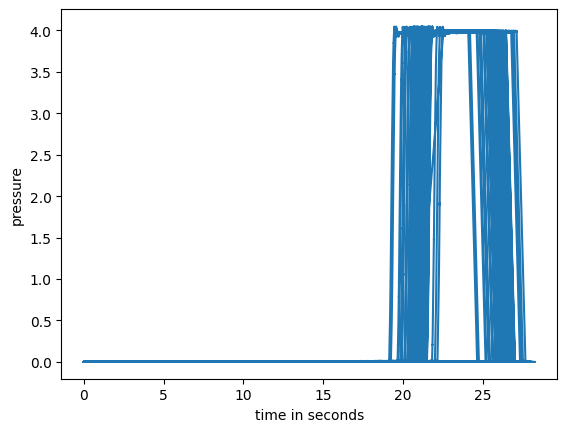

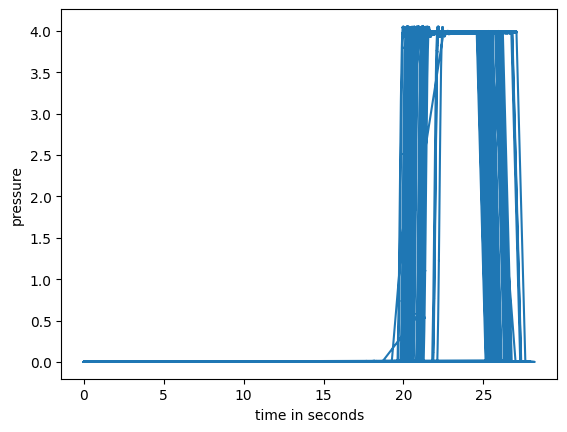

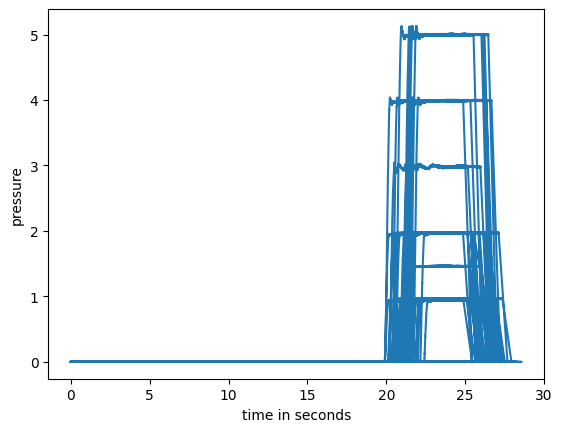

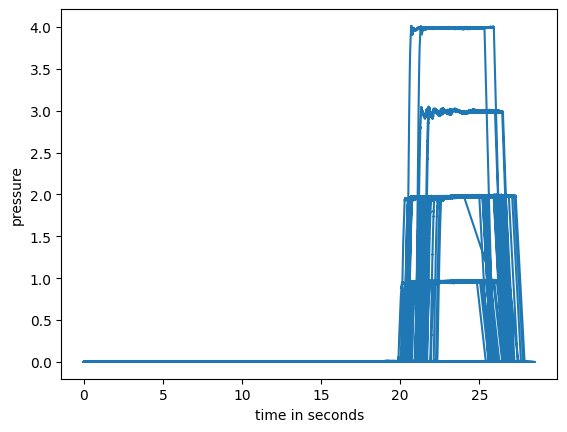

In [11]:
df.groupby("group").plot(x = "timestamp", y ="pressure",  xlabel="time in seconds", ylabel="pressure", subplots=True, legend=False)

## Split data

In [7]:
# Quelle: https://stackoverflow.com/questions/54797508/how-to-generate-a-train-test-split-based-on-a-group-id
train_inds, test_inds = next(GroupShuffleSplit(test_size=.33, n_splits=1, random_state = seed).split(df, groups=df["id"]))
train = df.iloc[train_inds]
test = df.iloc[test_inds]

print("Number of training cases:", train["id"].nunique())
print("Number of test cases:", test["id"].nunique())

Number of training cases: 139
Number of test cases: 69


## Prepare data for sktime
As we have seen before the length of our time series varies between cases. Most time series classification algorithms require equal-length time series. `sktime` offers various options to impute a time series, but because of the form of our data just padding the sequence at the beginning seems to be the appropriate solution.

(At first I tried to use `keras` to build a prediction model, but ~200 cases did not lead to desirable results. That is why `keras` is used for padding the sequence.)

In [10]:
# Create X and scale it
mns = MinMaxScaler()
df[["pressure"]] = mns.fit_transform(df[["pressure"]])

X_train = train.groupby("id")['pressure'].apply(list)
X_test = test.groupby("id")['pressure'].apply(list)

# Padding sequence with keras
X_train = keras.preprocessing.sequence.pad_sequences(X_train, dtype='float64', padding='pre', truncating='pre', maxlen=20017)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, dtype='float64', padding='pre', truncating='pre', maxlen=20017)

# For some some reason sktime is not able to handle 2d numpy arrays. Easiest way forward is transforming to an 3d numpy array.
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],1))

X_train = X_train.reshape((X_train.shape[0],1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0],1, X_test.shape[1]))

(139, 1, 20017)

Create target variables

In [17]:
y_train = train.groupby('id')['group'].unique().to_list()
y_train = np.array(y_train).astype('int').astype('str').squeeze()

y_test = test.groupby('id')['group'].unique().to_list()
y_test = np.array(y_test).astype('int').astype('str').squeeze()

y_train_binary = np.select([y_train == '2', y_train == '3'], ['1','1'], y_train)
y_test_binary = np.select([y_test == '2', y_test == '3'], ['1','1'], y_test)

## Modelling data
I use a times series classification algorithm called ROCKET and the newer version called miniROCKET.
* https://pub.towardsai.net/rocket-fast-and-accurate-time-series-classification-f54923ad0ac9
* https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/10_Time_Series_Classification_and_Regression_with_MiniRocket.ipynb

The original project was done with ROCKET and I added miniROCKET during the DSSGx application, to see how it performance. Moreover I am adding a dummy classifier for comparison.

MiniRocket is able to use sequences of unequal length, but for simplicity we are using the padded sequence. I should to some benchmarking for equal vs unequal length.

### Binary classification
For the binary classification our data is imbalanced, but it is not severe enough to oversample the correct classifications or use something like SMOTE.

#### Baseline

In [34]:
classifier = DummyClassifier(strategy="prior")
classifier.fit(X_train, y_train_binary)
classifier.score(X_test, y_test_binary)

0.782608695652174

#### ROCKET

In [47]:
rocket = Rocket()  # by default, ROCKET uses 10,000 kernels
rocket.fit(X_train)
X_train_transform = rocket.transform(X_train)

classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)

In [48]:
classifier.fit(X_train_transform, y_train_binary)

X_test_transform = rocket.transform(X_test)

classifier.score(X_test_transform, y_test_binary)

c:\Users\ystad\GitHub\dssgx-application\time-series-classification\rocket\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alphas to: original_alphas * n_samples. 
  warnings.warn(


0.9565217391304348

In [49]:
y_pred = classifier.predict(X_test_transform)
print(classification_report(y_pred,y_test_binary))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91        18
           1       0.94      1.00      0.97        51

    accuracy                           0.96        69
   macro avg       0.97      0.92      0.94        69
weighted avg       0.96      0.96      0.96        69



c:\Users\ystad\GitHub\dssgx-application\time-series-classification\rocket\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


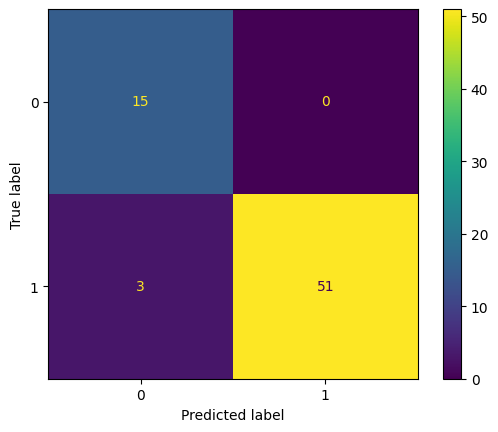

In [50]:
plot_confusion_matrix(classifier,X_test_transform,y_test_binary)

#### miniROCKET

In [43]:
minirocket = MiniRocket()  
minirocket.fit(X_train)

X_train_transform = minirocket.transform(X_train)
X_train_transform.shape

# Fit my classifier
scaler = StandardScaler(with_mean=False)
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))

In [44]:
X_train_scaled_transform = scaler.fit_transform(X_train_transform)
classifier.fit(X_train_scaled_transform, y_train_binary)

# Transform data
X_test_transform = minirocket.transform(X_test)

# Classify test data
X_test_scaled_transform = scaler.transform(X_test_transform)
classifier.score(X_test_scaled_transform, y_test_binary)

0.927536231884058

In [45]:
y_pred = classifier.predict(X_test_scaled_transform)
print(classification_report(y_pred,y_test_binary))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86        20
           1       0.91      1.00      0.95        49

    accuracy                           0.93        69
   macro avg       0.95      0.88      0.90        69
weighted avg       0.93      0.93      0.92        69



c:\Users\ystad\GitHub\dssgx-application\time-series-classification\rocket\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


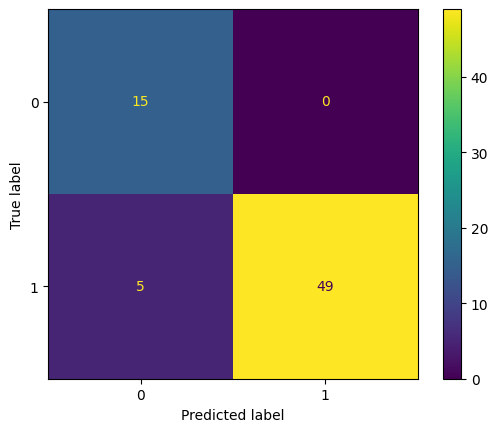

In [46]:
plot_confusion_matrix(classifier,X_test_scaled_transform,y_test_binary)

### Classification with all four classes
For that we just redo the models from above but we use the non-binary y

### Baseline

In [32]:
classifier = DummyClassifier(strategy="prior")
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

0.2318840579710145

### ROCKET

In [39]:
rocket = Rocket()  # by default, ROCKET uses 10,000 kernels
rocket.fit(X_train)
X_train_transform = rocket.transform(X_train)

classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)

In [40]:
classifier.fit(X_train_transform, y_train)

X_test_transform = rocket.transform(X_test)

classifier.score(X_test_transform, y_test)

c:\Users\ystad\GitHub\dssgx-application\time-series-classification\rocket\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alphas to: original_alphas * n_samples. 
  warnings.warn(


0.9130434782608695

In [41]:
y_pred = classifier.predict(X_test_transform)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87        17
           1       1.00      0.85      0.92        20
           2       0.86      1.00      0.92        18
           3       0.88      1.00      0.93        14

    accuracy                           0.91        69
   macro avg       0.92      0.92      0.91        69
weighted avg       0.92      0.91      0.91        69



c:\Users\ystad\GitHub\dssgx-application\time-series-classification\rocket\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


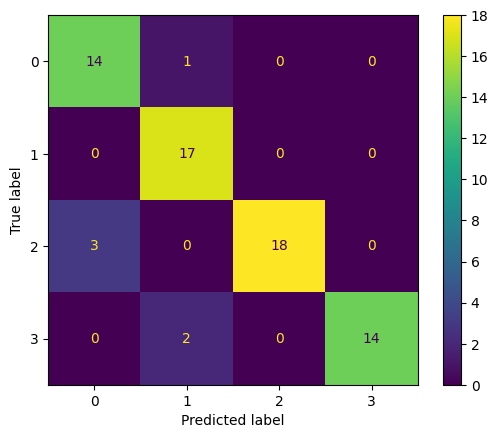

In [42]:
plot_confusion_matrix(classifier,X_test_transform,y_test)

### miniROCKET

In [35]:
minirocket = MiniRocket()  
minirocket.fit(X_train)

X_train_transform = minirocket.transform(X_train)
X_train_transform.shape

# Fit my classifier
scaler = StandardScaler(with_mean=False)
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))

In [36]:
X_train_scaled_transform = scaler.fit_transform(X_train_transform)
classifier.fit(X_train_scaled_transform, y_train)

# Transform data
X_test_transform = minirocket.transform(X_test)

# Classify test data
X_test_scaled_transform = scaler.transform(X_test_transform)
classifier.score(X_test_scaled_transform, y_test)

0.8695652173913043

In [37]:
y_pred = classifier.predict(X_test_scaled_transform)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.93      0.74      0.82        19
           1       0.82      0.93      0.87        15
           2       0.81      1.00      0.89        17
           3       0.94      0.83      0.88        18

    accuracy                           0.87        69
   macro avg       0.88      0.88      0.87        69
weighted avg       0.88      0.87      0.87        69



c:\Users\ystad\GitHub\dssgx-application\time-series-classification\rocket\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


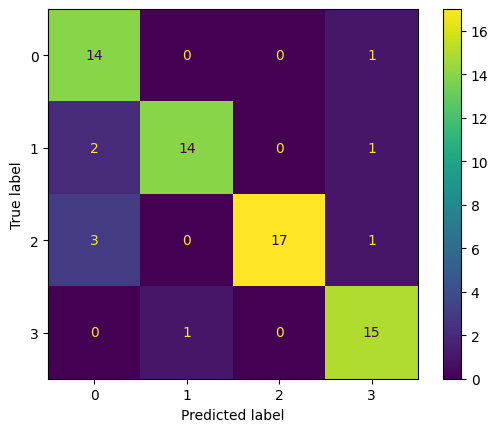

In [38]:
plot_confusion_matrix(classifier,X_test_scaled_transform,y_test)